how to use

1 set up dataset and model parameter\
2 train a teacher model\
3 train student\
4 validate the student model on dataset

#mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# dependencies

In [27]:
import tarfile
import os
from torch.utils.data import Dataset
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import DataLoader
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

import torch
from torch.utils.data import DataLoader
from collections import Counter

from torch.utils.data import TensorDataset, ConcatDataset, DataLoader


import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader, random_split

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np

from torchvision.transforms import Resize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from copy import deepcopy
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import torchvision.transforms.functional as TF

#function

In [41]:
def clean_data(device,confident_dataset_with_pseudo_labels,  model,batch_size = 64, some_confidence_threshold = 0.2):
  model = model.eval()

  dataloader = DataLoader(confident_dataset_with_pseudo_labels, batch_size=batch_size, shuffle=False)  # Adjust batch_size as per your requirement



  model.to(device)
  X, y = extract_features(dataloader, model)
  X = X.cpu().numpy()
  y = y.cpu().numpy()

  # Normalize features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Apply Gaussian Mixture Model
  gmm = GaussianMixture(n_components=100, random_state=42)
  gmm.fit(X_scaled)
  probs = gmm.predict_proba(X_scaled)
  hard_clusters = np.argmax(probs, axis=1)

  confidence_scores = []
  noisy_indices = []

  for i in range(100):
      cluster_indices = np.where(hard_clusters == i)[0]
      cluster_labels = y[cluster_indices]
      if len(cluster_labels) == 0:
          continue
      most_common_label = np.bincount(cluster_labels).argmax()
      most_common_label_count = np.bincount(cluster_labels)[most_common_label]
      total_count = len(cluster_labels)
      confidence = most_common_label_count / total_count

      # Check each data point in this cluster
      for idx in cluster_indices:
          if y[idx] != most_common_label and confidence < some_confidence_threshold:
              noisy_indices.append(idx)

  filtered_dataset = FilteredDataset(deepcopy(confident_dataset_with_pseudo_labels), noisy_indices)
  unlabel_filtered_dataset = UnlabelDataset_filted(deepcopy(confident_dataset_with_pseudo_labels), noisy_indices)
  print(len(filtered_dataset ))
  print(len(unlabel_filtered_dataset))
  return unlabel_filtered_dataset, filtered_dataset


def extract_features(dataloader, model):
    features = []
    labels = []
    with torch.no_grad():
        i=0
        for imgs, lbls in dataloader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            if i%100 ==0:
              print(f"index {i}")
            i+=1
            feats = model(imgs)
            features.append(feats)
            labels.append(lbls)
    features = torch.cat(features)
    labels = torch.cat(labels)
    return features, labels


def decompress_zip(file_path, extract_to_folder=None):
    """
    Decompresses a zip file to the specified folder.

    :param file_path: The path to the zip file.
    :param extract_to_folder: The folder to extract the files into. If None, extracts in the same directory as the zip file.
    :return: A list of file names that were extracted.
    """
    if extract_to_folder is None:
        extract_to_folder = os.path.dirname(file_path)

    with tarfile.open(file_path, "r:gz") as tar:
         tar.extractall(path=extract_to_folder)

class CustomDataset(Dataset):
    def __init__(self, data_path,csv_name, transform=None):
        self.data_pth_abs = data_path
        path = data_path+"task2/train_data/"+csv_name
        #print(path)
        self.data = pd.read_csv(path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data_pth_abs+self.data.iloc[idx, 0]
        #print(img_path)
        #print(self.data)
        label = self.data.iloc[idx, 1]

        image = Image.open(img_path)

        if image.mode == 'L':
            image = image.convert('RGB')


        if self.transform:
            image = self.transform(image)
        return image, label
    def count_unique_labels(self):
      return self.data.iloc[:, 1].nunique()

class UnlabeledDataset(Dataset):
    def __init__(self, data_path, transform=None):
        """
        Args:
            data_path (string): Path to the directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_path = data_path + "task2/train_data/images/unlabeled"
        self.transform = transform
        self.image_paths = [os.path.join(self.data_path, fname) for fname in os.listdir(self.data_path)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        if image.mode == 'L':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image




def compute_metrics(outputs, labels):
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    return accuracy, precision, recall, f1


def smooth_labels(labels, num_classes, smoothing=0.1):
    """
    Apply label smoothing.
    :param labels: torch.Tensor, the labels.
    :param num_classes: int, the number of classes.
    :param smoothing: float, the smoothing factor.
    """
    with torch.no_grad():
        labels = labels.unsqueeze(1)
        batch_size = labels.size(0)

        true_dist = torch.zeros(batch_size, num_classes, device=labels.device)

        true_dist.scatter_(1, labels, 1.0)

        true_dist = true_dist * (1 - smoothing) + (smoothing / num_classes)
    return true_dist

def train(device, num_classes, class_weights, model, optimizer, criterion,  train_loader, val_loader, num_epochs, patience=3, path_to_save_model = "'best_model.pth'"):
  print(device)
  model.to(device)
  best_val_accuracy = 0
  best_val_loss = float('inf')
  for epoch in range(num_epochs):
      running_loss = 0.0
      correct_train = 0
      total_train = 0

      epoch_loss = 0.0
      epoch_acc = 0.0
      epoch_precision = 0.0
      epoch_recall = 0.0
      epoch_f1 = 0.0
      num_batches = 0



      # Training Phase
      model.train()
      for inputs, labels in train_loader:
          transform_to_size= Resize(size=(img_size,img_size), antialias=True)
          inputs = transform_to_size(inputs)
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = model(inputs)

          smoothed_labels = smooth_labels(labels, num_classes)
          loss = criterion(outputs, smoothed_labels, class_weights)


          acc, precision, recall, f1 = compute_metrics(outputs, labels)
          epoch_acc += acc
          epoch_precision += precision
          epoch_recall += recall
          epoch_f1 += f1
          num_batches += 1

          loss.backward()
          optimizer.step()
          loss_item = loss.item()
          epoch_loss += loss_item
          running_loss += loss_item
          _, predicted = torch.max(outputs.data, 1)



          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

      epoch_loss /= num_batches
      epoch_acc /= num_batches
      epoch_precision /= num_batches
      epoch_recall /= num_batches
      epoch_f1 /= num_batches

      print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1 Score: {epoch_f1:.4f}")





      train_accuracy = 100 * correct_train / total_train

      model.eval()
      correct_val = 0
      total_val = 0

      running_loss1 = 0.0
      with torch.no_grad():
          for inputs, labels in val_loader:
              transform_to_size=  transforms.Resize((img_size, img_size),antialias=True)
              inputs = transform_to_size(inputs)
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              smoothed_labels = smooth_labels(labels, num_classes)
              loss1 = criterion(outputs, smoothed_labels, class_weights)
              running_loss1 += loss1.item()
              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      val_accuracy = 100 * correct_val / total_val


      val_loss = running_loss1 / len(val_loader)

      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
          print("Improved validation loss. Saving model.")
          torch.save(model.state_dict(), 'best_model.pth')
      else:
          patience_counter += 1
          print(f"No improvement in validation loss for {patience_counter} epochs.")

      if patience_counter >= patience:
          print(f"Stopping early at epoch {epoch+1} due to no improvement in validation loss.")
          break

      print(f'Epoch {epoch+1}/{num_epochs}, '
            f'Train Loss: {running_loss/len(train_loader):.4f}, '
            f'Train Accuracy: {train_accuracy:.2f}%, '
            f'Train Loss: {running_loss1/len(val_loader):.4f}, '
            f'Validation Accuracy: {val_accuracy:.2f}%')

      if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
          print("best model")
          torch.save(model.state_dict(), path_to_save_model)

  print('Finished Training')
  return model

def one_hot_encode(labels, num_classes, device):
    one_hot = torch.eye(num_classes, device=device)
    return one_hot[labels]

def custom_cross_entropy(input, target, weight=None):
    """
    Custom cross entropy loss for smoothed labels.
    :param input: Logits from the model (before softmax).
    :param target: Smoothed labels (2D tensor).
    :param weight: Class weights (optional).
    """
    log_probs = torch.nn.functional.log_softmax(input, dim=1)
    loss = -torch.sum(target * log_probs, dim=1)

    if weight is not None:
        loss *= weight[target.argmax(dim=1)]

    return loss.mean()

def load_list(file_path ):
  loaded_list = []

  if not os.path.exists(file_path):
      with open(file_path, 'w') as file:
          file.write('')

  with open(file_path, 'r') as file:
      for line in file:
          loaded_list.append(line.strip())
  return loaded_list


def evaluate_model(model, validation_loader, criterion,class_weights, num_classes=100):




  model.eval()
  correct_val = 0
  total_val = 0

  running_loss1 = 0.0
  with torch.no_grad():
      for inputs, labels in validation_loader:
          transform_to_size=  transforms.Resize((img_size, img_size),antialias=True)
          inputs = transform_to_size(inputs)
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          smoothed_labels = smooth_labels(labels, num_classes)
          loss1 = criterion(outputs, smoothed_labels, class_weights)

          running_loss1 += loss1.item()
          _, predicted = torch.max(outputs.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

  val_accuracy = 100 * correct_val / total_val
  print(f"accuracy curent model on val {val_accuracy}")
  return val_accuracy


def blend_weights(teacher_model, student_model, alpha=0.5):
    """
    Blends the weights of the teacher and student models.

    :param teacher_model: The teacher model.
    :param student_model: The student model.
    :param alpha: Blending factor, a value between 0 and 1.
                  alpha=1 means full student weights, alpha=0 means full teacher weights.
    """
    alpha = max(0, min(1, alpha))
    for teacher_param, student_param in zip(teacher_model.parameters(), student_model.parameters()):
        teacher_param.data = alpha * student_param.data + (1 - alpha) * teacher_param.data


class FilteredDataset(Dataset):
    def __init__(self, original_dataset, noisy_indices):
        self.original_dataset = original_dataset
        self.noisy_indices = set(noisy_indices)
        self.filtered_indices = [i for i in range(len(original_dataset)) if i not in self.noisy_indices]

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
      original_idx = self.filtered_indices[idx]
      data, label = self.original_dataset[original_idx]
      return data.clone().detach().requires_grad_(True), label


class UnlabelDataset_filted(Dataset):
    def __init__(self, original_dataset, noisy_indices):
        self.original_dataset = original_dataset
        self.noisy_indices = set(noisy_indices)
        self.filtered_indices = [i for i in range(len(original_dataset)) if i in self.noisy_indices]

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        # Map the new index to the original index
        original_idx = self.filtered_indices[idx]
        data, label = self.original_dataset[idx]
        return data.clone().detach().requires_grad_(True)


def calculate_class_weights(dataset, num_classes=100):
    # Count the number of samples for each class
    class_counts = Counter([label for _, label in dataset])

    # Calculate the weight for each class
    num_samples = len(dataset)
    class_weights = {class_id : num_samples / (num_classes * count)
                     for class_id, count in class_counts.items()}

    # Ensure weights are set for all classes, not just those in class_counts
    for cls in range(num_classes):
        class_weights.setdefault(cls, 1.0)

    # Convert to a list where the index corresponds to the class ID
    weights = [class_weights[i] for i in range(num_classes)]

    return torch.tensor(weights, dtype=torch.float)


'''
class CustomDataset_t_s(Dataset):
    def __init__(self, file_paths=None, labels=None, transform=None, save_dir='dataset_images'):
        self.file_paths = []  # List of file paths
        self.labels = []
        self.transform = transform
        self.save_dir = save_dir
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx])

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, int(label)

    def add_data(self, new_data, new_label):
        # Generate a unique filename for the new image
        new_filename = f'image_{len(self.file_paths)}.png'
        new_file_path = os.path.join(self.save_dir, new_filename)
        new_data_image = TF.to_pil_image(new_data)
        # Save the new image to disk
        #print(new_file_path)
        new_data_image.save(new_file_path)

        # Update the dataset
        self.file_paths.append(new_file_path)
        self.labels = np.append(self.labels, new_label)

    def __del__(self):
        # Cleanup: Delete the images when the dataset object is deleted
        for file_path in self.file_paths:
            if os.path.exists(file_path):
                os.remove(file_path)
        # Optionally, delete the directory if it's empty
        print("Dataset images and directory have been cleaned up.")
'''

class CustomDataset_t_s(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels.cpu().numpy()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_point = self.data[idx]
        label = self.labels[idx]
        image_tensor = data_point
        if image_tensor.shape[0] < image_tensor.shape[2]:
          image_tensor = image_tensor.permute(1, 2, 0)

        # Convert to numpy array
        image_array = image_tensor.detach().numpy()

        # Convert to PIL Image
        image = Image.fromarray((image_array * 255).astype('uint8'))



        if image.mode == 'L':
            image = image.convert('RGB')


        #print("sdfsdfsd")
        if self.transform:
            image = self.transform(image)

        return image, label


def calculate_class_thresholds(dataset, b_alpha):
    # Dummy function to calculate per-class thresholds based on dataset and b_alpha
    # Replace with actual logic
    num_classes = 100  # Update with actual number of classes
    return [0.7 for _ in range(num_classes)]


#dataset

In [5]:

data_pth = "/content/gdrive/MyDrive/sejour_aca/aait/task2.tar.gz"
decompress_zip(data_pth,"./")

# train teacher

## dataset teacher

### parameter

In [ ]:

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_size = 224
batch_size = 32  # Adjust as needed
# Set the random seed for reproducibility
random_seed = 42
train_proportion = 0.8  # 80% for training


unlabeled_dataset = UnlabeledDataset(data_path='/content/', transform=transform)
c = CustomDataset(data_path='/content/', csv_name = 'annotations.csv', transform=transform)

## seting up dataset

In [ ]:
torch.manual_seed(random_seed)

In [ ]:
'''
file_path = '/content/indices_list.txt'
indices_list = load_list(file_path )

file_path = '/content/noisy_indices2.txt'
noise_list = load_list(file_path )

file_path = '/content/pseudo_labels_list.txt'
pseudo_labels_list = load_list(file_path )
'''

In [ ]:
#indices_list = [int(i) for i in indices_list]

In [ ]:


eval_proportion = 1 - train_proportion

train_size = int(train_proportion * len(labeled_dataset ))
val_size = len(labeled_dataset) - train_size


train_dataset, val_dataset = random_split(labeled_dataset , [train_size, val_size])



# Create DataLoaders for training and evaluation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## train teacher

### parameter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


path_model_teacher = './best_model.pth'
num_classes = 100
num_epochs = 30


#model choice
resnet50 = models.resnet50(pretrained=True).to(device)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

### main

In [ ]:

class_weights = calculate_class_weights(labeled_dataset )

optimizer = optim.Adam(resnet50.parameters(), lr=0.001)


class_weights = class_weights.to(device)
criterion = custom_cross_entropy
train(device, num_classes,class_weights, resnet50, optimizer, criterion,  train_loader, val_loader, num_epochs, patience=3, path_to_save_model =path_model_teacher)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda
Epoch 1, Loss: 0.0000, Accuracy: 0.0513, Precision: 0.0249, Recall: 0.0368, F1 Score: 0.0266
Improved validation loss. Saving model.
Epoch 1/30, Train Loss: 4.3010, Train Accuracy: 5.13%, Train Loss: 3.9600, Validation Accuracy: 10.11%
best model
Epoch 2, Loss: 0.0000, Accuracy: 0.1327, Precision: 0.0773, Recall: 0.0865, F1 Score: 0.0775
Improved validation loss. Saving model.
Epoch 2/30, Train Loss: 3.8048, Train Accuracy: 13.26%, Train Loss: 3.7180, Validation Accuracy: 16.18%
best model
Epoch 3, Loss: 0.0000, Accuracy: 0.1915, Precision: 0.1174, Recall: 0.1251, F1 Score: 0.1162
Improved validation loss. Saving model.
Epoch 3/30, Train Loss: 3.5497, Train Accuracy: 19.18%, Train Loss: 3.4822, Validation Accuracy: 22.32%
best model
Epoch 4, Loss: 0.0000, Accuracy: 0.2590, Precision: 0.1642, Recall: 0.1680, F1 Score: 0.1603
Improved validation loss. Saving model.
Epoch 4/30, Train Loss: 3.2948, Train Accuracy: 25.92%, Train Loss: 3.2538, Validation Accuracy: 28.35%
best model
Epoc

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#analyse dataset is balanced

dataset to analyse

In [ ]:
dataset = labeled_dataset

## code

In [ ]:

# Count the frequency of each class
class_counts = {}
for _, label in filtered_dataset:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Sort the classes if they are not numeric or if you want them in order
class_labels = sorted(class_counts.keys())

# Get counts in the same order as class labels
counts = [class_counts[label] for label in class_labels]


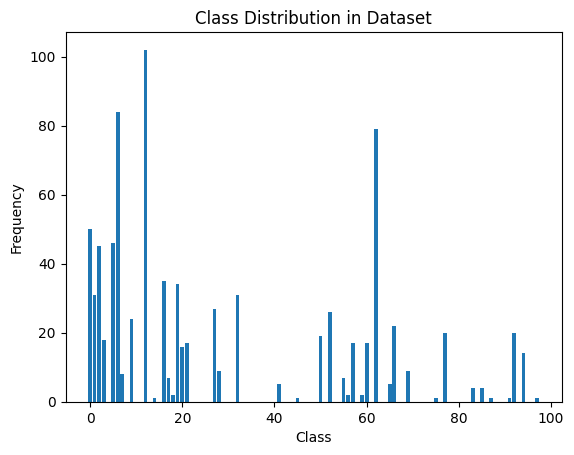

In [ ]:
import matplotlib.pyplot as plt
# Create a bar chart
plt.bar(class_labels, counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Dataset')
plt.show()

# train student with teacher

In [42]:
random_seed = 42
batch_size = 32  # Adjust as needed
batch_size_clean = 64
model_path = "/content/gdrive/MyDrive/model/best_model2_task2.pth"


student_path = 'best_model.pth'
student_epochs = 5
img_size = 224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

labeled_dataset = CustomDataset(data_path='/content/', csv_name = 'annotations.csv', transform=transform)
confidence_threshold_clean_data = 0.7

# Define the proportions for splitting
train_proportion = 0.8
eval_proportion = 1 - train_proportion

nb_classes = 100

num_iterations = 15

initial_threshold = 0.70
threshold_increment = 0.05
threshold_decrement = 0.03
max_threshold = 0.95
min_threshold = 0.60

alpha_student = 0.8
alpha_teacher = 0.2

b_alpha = 0.1 # alpha for class thresholds

lr_student = 0.001

patience_training = 4



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from copy import deepcopy
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader

torch.manual_seed(random_seed)

teacher_model = models.resnet50(pretrained=False)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, nb_classes)


teacher_model.load_state_dict(torch.load(model_path))

unlabeled_dataset, labeled_dataset = clean_data(device, labeled_dataset, teacher_model, batch_size = batch_size, some_confidence_threshold = confidence_threshold_clean_data)

train_loader_unlabeled = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)

train_size = int(train_proportion * len(labeled_dataset))
val_size = len(labeled_dataset) - train_size

train_dataset, val_dataset = random_split(labeled_dataset, [train_size, val_size])


val_loader = DataLoader(val_dataset, batch_size=batch_size)

teacher_model.to(device)

confidence_threshold = initial_threshold
previous_accuracy = 0


class_weights = calculate_class_weights(labeled_dataset)
class_weights = class_weights.to(device)
criterion = custom_cross_entropy

student_model = models.resnet50(pretrained=True)
student_model.fc = nn.Linear(student_model.fc.in_features, nb_classes) # 100 classes


student_model.to(device)
blend_weights(student_model,teacher_model, alpha=alpha_teacher)
optimizer = optim.Adam(student_model.parameters(), lr=lr_student)



class_specific_thresholds = calculate_class_thresholds(labeled_dataset, b_alpha)

unique_indices = set()
for iteration in range(num_iterations):
    # Generate pseudo-labels for the unlabeled dataset
    teacher_model.eval()
    student_model.eval()
    # Evaluate the model on the validation set
    current_accuracy = evaluate_model(teacher_model, val_loader,criterion, class_weights)  # Implement evaluate_model function

    # Adjust the threshold based on validation performance
    if current_accuracy > previous_accuracy:
        confidence_threshold = min(confidence_threshold + threshold_increment, max_threshold)
    elif current_accuracy <= previous_accuracy:
        confidence_threshold = max(confidence_threshold - threshold_decrement, min_threshold)


    pseudo_labels_list = []
    indices_list = []

    accumulated_pseudo_labels = []
    accumulated_unlabeled_data = []





    with torch.no_grad():
        for i, inputs in enumerate(train_loader_unlabeled):
            transform_to_size=  transforms.Resize((img_size, img_size),antialias=True)
            inputs = transform_to_size(inputs)
            inputs = inputs.to(device)
            outputs = teacher_model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probabilities, 1)

            for class_idx in range(100):  # Assuming 100 classes
                class_threshold = class_specific_thresholds[class_idx]
                class_mask = (max_probs > class_threshold)
                confident_indices = class_mask.nonzero(as_tuple=False).view(-1)

                confident_predictions = predicted[confident_indices].cpu().numpy()
                pseudo_labels_list.extend(confident_predictions)
                indices_list.extend([int(ele + i * inputs.shape[0]) for ele in confident_indices.cpu().numpy()])


    #initial_size = len(indices_list)  # An initial estimate
    #num_features = [3, 224, 224]  # For RGB images of size 224x224
    #del confident_dataset_with_pseudo_labels
    #confident_dataset_with_pseudo_labels = CustomDataset_t_s(initial_size, num_features, transform)
    '''
    confident_dataset_with_pseudo_labels = CustomDataset_t_s(transform=transform, save_dir='/content/temp_img/')

    for idx, pseudo_label in zip(indices_list, pseudo_labels_list):
        confident_dataset_with_pseudo_labels.add_data(unlabeled_dataset[idx], pseudo_label)
        #confident_dataset_with_pseudo_labels.add_data(unlabeled_dataset[idx], pseudo_label)
    '''

    for idx, pseudo_label in zip(indices_list, pseudo_labels_list):
        accumulated_pseudo_labels.append(pseudo_label)
        accumulated_unlabeled_data.append(unlabeled_dataset[idx])


    confident_dataset_with_pseudo_labels = CustomDataset_t_s(accumulated_unlabeled_data, torch.tensor(accumulated_pseudo_labels), transform=transform)


    #confident_dataset_with_pseudo_labels = CustomDataset_t_s(accumulated_unlabeled_data, torch.tensor(accumulated_pseudo_labels))
    len(f"len confidence {confident_dataset_with_pseudo_labels}")
    #del accumulated_unlabeled_data, indices_list,pseudo_labels_list
    import gc
    gc.collect()
    if len(confident_dataset_with_pseudo_labels)<10:
      confidence_threshold-=0.05
      continue
    # clean the data
    unlabeled_dataset, data_plus_cleaned = clean_data(device, confident_dataset_with_pseudo_labels, teacher_model, batch_size = batch_size_clean, some_confidence_threshold = current_accuracy/100/3*2)

    train_loader_unlabeled = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)

    combined_dataset = ConcatDataset([train_dataset, data_plus_cleaned])


    print(f"new dataset of len {len(combined_dataset)}")
    print(f"dataset increase by {len(combined_dataset)/len(train_dataset)*100}%")


    combined_train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    #combined_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


    #val_loader = combined_val_loader
    # Train the student model on the combined dataset



    print(f"Iteration {iteration+1}")
    criterion = custom_cross_entropy

    train(device,nb_classes, class_weights, student_model, optimizer, criterion,  combined_train_loader, val_loader, student_epochs, patience=patience_training, path_to_save_model= student_path)
    student_model.load_state_dict(torch.load(student_path))

    # Update the teacher model
    blend_weights(teacher_model,student_model, alpha=alpha_teacher)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


index 0
index 100
index 200
index 300
index 400
index 500
index 600
index 700
index 800
index 900
index 1000
index 1100
index 1200
index 1300
index 1400
index 1500


In [ ]:
!cp /content/best_model.pth /content/gdrive/MyDrive/model/best_model_task1_final.pth

#validation of model

##functions

In [ ]:
class UnlabeledDataset1(Dataset):
    def __init__(self, data_path, transform=None):
        """
        Args:
            data_path (string): Path to the directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_path = data_path + "task1/val_data/"
        #self.data_path = data_path + "task1/train_data/images/unlabeled"
        self.transform = transform
        self.image_paths = [os.path.join(self.data_path, fname) for fname in os.listdir(self.data_path)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        if image.mode == 'L':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

#main validation

parameter

In [ ]:
model_path = '/content/best_model.pth'
dataset = UnlabeledDataset1(data_path='/content/', transform=transform)
batch_s = 500
output_csv_final = 'sorted_predicted_results3.csv'

## validation code

In [ ]:
import torchvision.models as models

model = models.resnet50(pretrained=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Linear(model.fc.in_features, 100)

model.load_state_dict(torch.load(model_path))
ensemble_model = model

ensemble_model.to(device)

In [ ]:
ensemble_model = teacher_model

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])




data_loader = DataLoader(dataset, batch_size=batch_s, shuffle=False)


model = ensemble_model

model.eval()

image_paths = []
predicted_classes = []


total = 0
for batch in tqdm(data_loader, desc='Classifying images', unit=' images'):
    inputs = batch.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    next = total + batch_s
    image_paths.extend(dataset.image_paths[total: next])
    total = total+ batch_s
    #print(len(predicted.tolist()))
    predicted_classes.extend(predicted.tolist())

result_df = pd.DataFrame({'Image_Path': image_paths, 'Predicted_Class': predicted_classes})

result_csv = './predicted_results.csv'
result_df.to_csv(result_csv, index=False)

print(f'Results saved to {result_csv}')
import pandas as pd

# Read the CSV file
input_csv = 'predicted_results.csv'
df = pd.read_csv(input_csv)

sorted_df = df.sort_values(by='Image_Path')

output_csv = 'sorted_predicted_results.csv'
sorted_df.to_csv(output_csv, index=False)

print(f'Sorted results saved to {output_csv}')

import pandas as pd

input_csv = 'predicted_results.csv'
df = pd.read_csv(input_csv)


df['Image_Number'] = df['Image_Path'].str.extract('(\d+)\.jpeg')

df['Image_Number'] = pd.to_numeric(df['Image_Number'])

sorted_df = df.sort_values(by='Image_Number')


output_csv = 'sorted_predicted_results.csv'

sorted_df.to_csv(output_csv, index=False)
print(f'Sorted results saved to {output_csv}')

input_csv = 'sorted_predicted_results.csv'
df = pd.read_csv(input_csv)

df['Image_Path'] = df['Image_Path'].apply(lambda x: x.split('/')[-1])
output_csv = 'sorted_predicted_results2.csv'
df.to_csv(output_csv, index=False)

print(f'Sorted results saved to {output_csv}')

import pandas as pd

input_csv = 'sorted_predicted_results2.csv'
df = pd.read_csv(input_csv)




df.rename(columns={'Image_Path': 'sample', 'Predicted_Class': 'label'}, inplace=True)



df = df.drop(columns=['Image_Number'])
df.to_csv(output_csv, index=False)

print(f'Updated results with "img" prefix saved to {output_csv_final}')


Classifying images: 100%|██████████| 10/10 [00:21<00:00,  2.14s/ images]

Results saved to ./predicted_results.csv
Sorted results saved to sorted_predicted_results.csv
Sorted results saved to sorted_predicted_results.csv
Sorted results saved to sorted_predicted_results2.csv
Updated results with "img" prefix saved to sorted_predicted_results3.csv
